# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

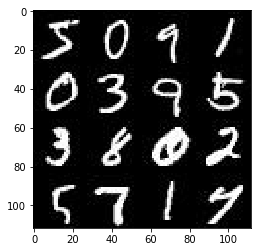

In [2]:
show_n_images = 16

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

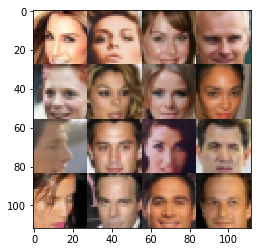

In [3]:
show_n_images = 16

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), \
    'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_image = tf.placeholder(tf.float32,[None,image_width,image_height,image_channels])
    tensor_Z = tf.placeholder(tf.float32,[None,z_dim])
    learn_rate = tf.placeholder(tf.float32)
    return input_image, tensor_Z, learn_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [58]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha=0.19
    batchSize,height_i,width_i,deepth_i = images.get_shape().as_list()
    kernal_size = 5
    stridesNum = 2
    with tf.variable_scope('discriminator',reuse=reuse):
        # Input layer is height_i x width_i x deepth_i
        Layer1 = tf.layers.conv2d(images, 64, kernal_size, strides=stridesNum, padding='same',\
                                  kernel_initializer=tf.contrib.layers.xavier_initializer())
        relu1 = tf.maximum(alpha * Layer1, Layer1)
        relu1 = tf.nn.dropout(relu1,0.8)
        # Now height_i-kernal_size x width_i/2 x 64
        #print(relu1.shape)
        
        Layer2 = tf.layers.conv2d(relu1, 128, kernal_size, strides=stridesNum, padding='same',\
                                  kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn2 = tf.layers.batch_normalization(Layer2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        relu2 = tf.nn.dropout(relu2,0.8)
        # height_i/4 x width_i/4 x 128
        #print(relu2.shape)
        
        Layer3 = tf.layers.conv2d(relu2, 256, kernal_size, strides=stridesNum, padding='same',\
                                  kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn3 = tf.layers.batch_normalization(Layer3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        relu3 = tf.nn.dropout(relu3,0.8)
        # height_i/8 x width_i/8 x 256
        #print(relu3.shape)
        
        Layer4 = tf.layers.conv2d(relu3, 512, kernal_size, strides=stridesNum, padding='same',\
                                  kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn4 = tf.layers.batch_normalization(Layer4, training=True)
        relu4 = tf.maximum(alpha * bn4, bn4)
        relu4 = tf.nn.dropout(relu4,0.8)
        # height_i/8 x width_i/8 x 256
        #print(relu4.shape)

        # Flatten it
        flat = tf.reshape(relu4, (-1, 4*4*512))
        logits = tf.layers.dense(flat, 1)
        #print(logits.shape)
        outputs = tf.sigmoid(logits)
    return outputs, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [59]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator',reuse=not is_train):
        kernal_size = 5
        strideNum = 2
        alpha=0.2
        # First fully connected layer
        gLayer1 = tf.layers.dense(z, 4*4*512)
        # Reshape it to start the convolutional stack
        gLayer1 = tf.reshape(gLayer1, (-1,4,4, 512))
        gLayer1 = tf.layers.batch_normalization(gLayer1, training=is_train)
        relu1 = tf.maximum(alpha * gLayer1, gLayer1)
        # 5x5x256 now
        #print(relu1.shape)        
        gLayer2 = tf.layers.conv2d_transpose(relu1, 256, 4, strides=1, padding='valid',\
                                             kernel_initializer=tf.contrib.layers.xavier_initializer())
        gLayer2 = tf.layers.batch_normalization(gLayer2, training=is_train)
        relu2 = tf.maximum(alpha * gLayer2, gLayer2)
        relu2 = tf.nn.dropout(relu2,0.8)
        #print(relu2.shape)
        gLayer3 = tf.layers.conv2d_transpose(relu2, 128, kernal_size, strides=strideNum, padding='same',\
                                             kernel_initializer=tf.contrib.layers.xavier_initializer())
        gLayer3 = tf.layers.batch_normalization(gLayer3, training=is_train)
        relu3 = tf.maximum(alpha * gLayer3, gLayer3)
        relu3 = tf.nn.dropout(relu3,0.8)
        # 14x14x128 now
        #print(relu3.shape)        
        gLayer4 = tf.layers.conv2d_transpose(relu3, 64, kernal_size, strides=strideNum, padding='same',\
                                  kernel_initializer=tf.contrib.layers.xavier_initializer())
        gLayer4 = tf.layers.batch_normalization(gLayer4, training=is_train)
        relu4 = tf.maximum(alpha * gLayer4, gLayer4)
        relu4 = tf.nn.dropout(relu4,0.8)
        # 14x14x128 now
        #print(relu4.shape)        
        # Output layer
        g_logits = tf.layers.conv2d_transpose(relu4, out_channel_dim, kernal_size, strides=1, padding='same',\
                                  kernel_initializer=tf.contrib.layers.xavier_initializer())
        # 28x28 x out_channel_dim now
        #print(g_logits.shape)        
        g_outputs = tf.tanh(g_logits)
    return g_outputs


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [60]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*0.9))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [61]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [62]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [67]:
import math
import time
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    step_count = 0
    
    input_real, input_z,l_rate = model_inputs(data_shape[2],data_shape[1],data_shape[3], z_dim)
    d_loss,g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt,g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    print_info_batch_cnt = 20
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        lastBatchesTime = time.time()
        for epoch_i in range(epoch_count):
            batch_cnt = 0
            for batch_images in get_batches(batch_size):
                batch_images = batch_images*2
                step_count += 1
                batch_cnt += 1
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                # TODO: Train Model
                
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z,l_rate:learning_rate })
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images,l_rate:learning_rate })
                # Run g_optim twice to make sure that d_loss does not go to zero
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images,l_rate:learning_rate })
                
                if step_count % print_info_batch_cnt == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Batch {}/{}...".format(batch_cnt,math.ceil(data_shape[0]/batch_images.shape[0])),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g),\
                          "This {} batches takes:{:.1f} sec".format(print_info_batch_cnt,(time.time()-lastBatchesTime)))
                    lastBatchesTime = time.time()
                    
                if step_count % 400 == 0:
                    show_generator_output(sess,25,input_z,data_shape[3],data_image_mode)
        show_generator_output(sess,25,input_z,data_shape[3],data_image_mode)                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/4... Batch 20/938... Discriminator Loss: 2.4262... Generator Loss: 0.3522 This 20 batches takes:35.4 sec
Epoch 1/4... Batch 40/938... Discriminator Loss: 2.2550... Generator Loss: 0.3585 This 20 batches takes:34.4 sec
Epoch 1/4... Batch 60/938... Discriminator Loss: 1.5567... Generator Loss: 0.7122 This 20 batches takes:34.4 sec
Epoch 1/4... Batch 80/938... Discriminator Loss: 0.9235... Generator Loss: 1.3386 This 20 batches takes:34.6 sec
Epoch 1/4... Batch 100/938... Discriminator Loss: 2.3996... Generator Loss: 0.4445 This 20 batches takes:34.4 sec
Epoch 1/4... Batch 120/938... Discriminator Loss: 1.1796... Generator Loss: 1.1474 This 20 batches takes:34.5 sec
Epoch 1/4... Batch 140/938... Discriminator Loss: 1.4666... Generator Loss: 0.8723 This 20 batches takes:34.5 sec
Epoch 1/4... Batch 160/938... Discriminator Loss: 1.8409... Generator Loss: 0.7175 This 20 batches takes:34.4 sec
Epoch 1/4... Batch 180/938... Discriminator Loss: 1.4552... Generator Loss: 0.6309 This 20 b

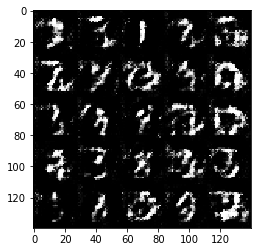

Epoch 1/4... Batch 420/938... Discriminator Loss: 1.4296... Generator Loss: 0.5941 This 20 batches takes:35.8 sec
Epoch 1/4... Batch 440/938... Discriminator Loss: 1.5868... Generator Loss: 0.8023 This 20 batches takes:34.5 sec
Epoch 1/4... Batch 460/938... Discriminator Loss: 1.4145... Generator Loss: 0.8255 This 20 batches takes:34.4 sec
Epoch 1/4... Batch 480/938... Discriminator Loss: 1.5758... Generator Loss: 0.9511 This 20 batches takes:34.4 sec
Epoch 1/4... Batch 500/938... Discriminator Loss: 1.5093... Generator Loss: 0.6328 This 20 batches takes:34.5 sec
Epoch 1/4... Batch 520/938... Discriminator Loss: 1.4074... Generator Loss: 0.9241 This 20 batches takes:34.4 sec
Epoch 1/4... Batch 540/938... Discriminator Loss: 1.4097... Generator Loss: 0.8406 This 20 batches takes:34.5 sec
Epoch 1/4... Batch 560/938... Discriminator Loss: 1.4582... Generator Loss: 1.2069 This 20 batches takes:34.5 sec
Epoch 1/4... Batch 580/938... Discriminator Loss: 1.4878... Generator Loss: 0.7665 This 

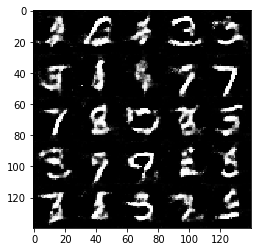

Epoch 1/4... Batch 820/938... Discriminator Loss: 1.2953... Generator Loss: 0.8709 This 20 batches takes:35.5 sec
Epoch 1/4... Batch 840/938... Discriminator Loss: 1.4485... Generator Loss: 0.5840 This 20 batches takes:34.4 sec
Epoch 1/4... Batch 860/938... Discriminator Loss: 1.3656... Generator Loss: 0.8823 This 20 batches takes:34.6 sec
Epoch 1/4... Batch 880/938... Discriminator Loss: 1.2064... Generator Loss: 0.7596 This 20 batches takes:34.5 sec
Epoch 1/4... Batch 900/938... Discriminator Loss: 1.2377... Generator Loss: 0.6867 This 20 batches takes:34.3 sec
Epoch 1/4... Batch 920/938... Discriminator Loss: 1.4792... Generator Loss: 0.7040 This 20 batches takes:34.4 sec
Epoch 2/4... Batch 3/938... Discriminator Loss: 1.4143... Generator Loss: 0.5310 This 20 batches takes:34.3 sec
Epoch 2/4... Batch 23/938... Discriminator Loss: 1.3746... Generator Loss: 0.8075 This 20 batches takes:34.3 sec
Epoch 2/4... Batch 43/938... Discriminator Loss: 1.4033... Generator Loss: 0.9311 This 20 b

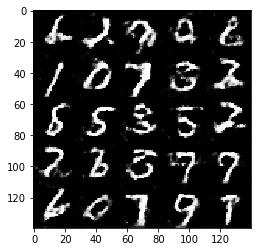

Epoch 2/4... Batch 283/938... Discriminator Loss: 1.4660... Generator Loss: 0.6643 This 20 batches takes:35.3 sec
Epoch 2/4... Batch 303/938... Discriminator Loss: 1.4360... Generator Loss: 0.8979 This 20 batches takes:34.6 sec
Epoch 2/4... Batch 323/938... Discriminator Loss: 1.2956... Generator Loss: 1.0710 This 20 batches takes:34.4 sec
Epoch 2/4... Batch 343/938... Discriminator Loss: 1.5790... Generator Loss: 0.6586 This 20 batches takes:34.4 sec
Epoch 2/4... Batch 363/938... Discriminator Loss: 1.3987... Generator Loss: 0.9007 This 20 batches takes:34.3 sec
Epoch 2/4... Batch 383/938... Discriminator Loss: 1.7748... Generator Loss: 0.8080 This 20 batches takes:34.3 sec
Epoch 2/4... Batch 403/938... Discriminator Loss: 1.5174... Generator Loss: 0.7280 This 20 batches takes:34.3 sec
Epoch 2/4... Batch 423/938... Discriminator Loss: 1.2228... Generator Loss: 1.0968 This 20 batches takes:34.3 sec
Epoch 2/4... Batch 443/938... Discriminator Loss: 1.1888... Generator Loss: 1.0525 This 

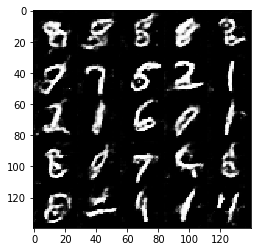

Epoch 2/4... Batch 683/938... Discriminator Loss: 1.5259... Generator Loss: 0.4630 This 20 batches takes:42.7 sec
Epoch 2/4... Batch 703/938... Discriminator Loss: 1.3392... Generator Loss: 1.2022 This 20 batches takes:42.2 sec
Epoch 2/4... Batch 723/938... Discriminator Loss: 1.3044... Generator Loss: 1.0882 This 20 batches takes:41.5 sec
Epoch 2/4... Batch 743/938... Discriminator Loss: 1.1291... Generator Loss: 1.0693 This 20 batches takes:40.9 sec
Epoch 2/4... Batch 763/938... Discriminator Loss: 1.5771... Generator Loss: 0.5151 This 20 batches takes:40.9 sec
Epoch 2/4... Batch 783/938... Discriminator Loss: 1.2047... Generator Loss: 0.9277 This 20 batches takes:42.5 sec
Epoch 2/4... Batch 803/938... Discriminator Loss: 1.5666... Generator Loss: 0.4155 This 20 batches takes:40.3 sec
Epoch 2/4... Batch 823/938... Discriminator Loss: 1.2879... Generator Loss: 1.0463 This 20 batches takes:40.5 sec
Epoch 2/4... Batch 843/938... Discriminator Loss: 1.4741... Generator Loss: 0.4721 This 

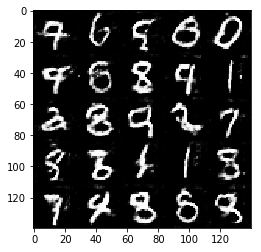

Epoch 3/4... Batch 146/938... Discriminator Loss: 1.3092... Generator Loss: 0.7478 This 20 batches takes:41.5 sec
Epoch 3/4... Batch 166/938... Discriminator Loss: 1.1594... Generator Loss: 0.7221 This 20 batches takes:39.7 sec
Epoch 3/4... Batch 186/938... Discriminator Loss: 1.2652... Generator Loss: 1.6738 This 20 batches takes:40.0 sec
Epoch 3/4... Batch 206/938... Discriminator Loss: 1.4903... Generator Loss: 0.7889 This 20 batches takes:39.7 sec
Epoch 3/4... Batch 226/938... Discriminator Loss: 0.9409... Generator Loss: 1.1377 This 20 batches takes:39.6 sec
Epoch 3/4... Batch 246/938... Discriminator Loss: 1.4490... Generator Loss: 0.7764 This 20 batches takes:39.7 sec
Epoch 3/4... Batch 266/938... Discriminator Loss: 1.2762... Generator Loss: 0.7158 This 20 batches takes:40.5 sec
Epoch 3/4... Batch 286/938... Discriminator Loss: 1.3291... Generator Loss: 1.5406 This 20 batches takes:40.2 sec
Epoch 3/4... Batch 306/938... Discriminator Loss: 1.3162... Generator Loss: 0.5470 This 

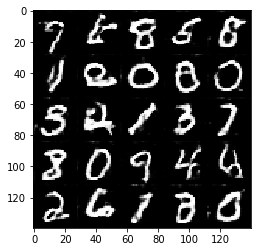

Epoch 3/4... Batch 546/938... Discriminator Loss: 1.1875... Generator Loss: 0.9247 This 20 batches takes:40.3 sec
Epoch 3/4... Batch 566/938... Discriminator Loss: 1.2887... Generator Loss: 0.6441 This 20 batches takes:39.7 sec
Epoch 3/4... Batch 586/938... Discriminator Loss: 1.4540... Generator Loss: 0.8824 This 20 batches takes:39.0 sec
Epoch 3/4... Batch 606/938... Discriminator Loss: 1.0848... Generator Loss: 0.9128 This 20 batches takes:39.3 sec
Epoch 3/4... Batch 626/938... Discriminator Loss: 1.6991... Generator Loss: 0.5873 This 20 batches takes:39.5 sec
Epoch 3/4... Batch 646/938... Discriminator Loss: 1.3846... Generator Loss: 0.5244 This 20 batches takes:39.9 sec
Epoch 3/4... Batch 666/938... Discriminator Loss: 1.0461... Generator Loss: 0.5810 This 20 batches takes:36.5 sec
Epoch 3/4... Batch 686/938... Discriminator Loss: 1.8529... Generator Loss: 0.3478 This 20 batches takes:34.4 sec
Epoch 3/4... Batch 706/938... Discriminator Loss: 1.0132... Generator Loss: 1.4496 This 

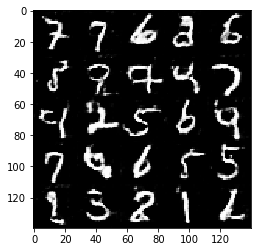

Epoch 4/4... Batch 9/938... Discriminator Loss: 1.8372... Generator Loss: 2.1633 This 20 batches takes:35.4 sec
Epoch 4/4... Batch 29/938... Discriminator Loss: 1.2516... Generator Loss: 1.5847 This 20 batches takes:34.3 sec
Epoch 4/4... Batch 49/938... Discriminator Loss: 1.3519... Generator Loss: 0.9401 This 20 batches takes:34.4 sec
Epoch 4/4... Batch 69/938... Discriminator Loss: 1.0060... Generator Loss: 0.9919 This 20 batches takes:34.3 sec
Epoch 4/4... Batch 89/938... Discriminator Loss: 1.3560... Generator Loss: 0.5503 This 20 batches takes:34.3 sec
Epoch 4/4... Batch 109/938... Discriminator Loss: 0.8760... Generator Loss: 1.0165 This 20 batches takes:34.5 sec
Epoch 4/4... Batch 129/938... Discriminator Loss: 1.8466... Generator Loss: 0.2715 This 20 batches takes:34.4 sec
Epoch 4/4... Batch 149/938... Discriminator Loss: 1.2114... Generator Loss: 0.9544 This 20 batches takes:34.5 sec
Epoch 4/4... Batch 169/938... Discriminator Loss: 1.0927... Generator Loss: 0.7198 This 20 bat

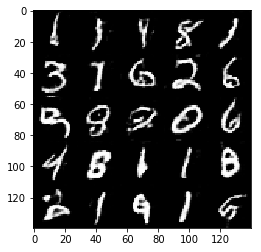

Epoch 4/4... Batch 409/938... Discriminator Loss: 1.8858... Generator Loss: 0.3193 This 20 batches takes:35.4 sec
Epoch 4/4... Batch 429/938... Discriminator Loss: 1.6498... Generator Loss: 2.6058 This 20 batches takes:34.5 sec
Epoch 4/4... Batch 449/938... Discriminator Loss: 0.8648... Generator Loss: 0.9636 This 20 batches takes:34.5 sec
Epoch 4/4... Batch 469/938... Discriminator Loss: 1.2298... Generator Loss: 1.8195 This 20 batches takes:34.7 sec
Epoch 4/4... Batch 489/938... Discriminator Loss: 0.9254... Generator Loss: 1.3035 This 20 batches takes:34.9 sec
Epoch 4/4... Batch 509/938... Discriminator Loss: 2.0124... Generator Loss: 0.3879 This 20 batches takes:34.9 sec
Epoch 4/4... Batch 529/938... Discriminator Loss: 0.9138... Generator Loss: 1.8884 This 20 batches takes:34.9 sec
Epoch 4/4... Batch 549/938... Discriminator Loss: 1.1904... Generator Loss: 0.5734 This 20 batches takes:34.9 sec
Epoch 4/4... Batch 569/938... Discriminator Loss: 1.1104... Generator Loss: 1.8237 This 

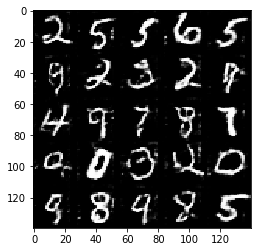

Epoch 4/4... Batch 809/938... Discriminator Loss: 0.8854... Generator Loss: 0.7025 This 20 batches takes:35.5 sec
Epoch 4/4... Batch 829/938... Discriminator Loss: 1.3127... Generator Loss: 0.7663 This 20 batches takes:34.3 sec
Epoch 4/4... Batch 849/938... Discriminator Loss: 1.2546... Generator Loss: 2.0215 This 20 batches takes:34.3 sec
Epoch 4/4... Batch 869/938... Discriminator Loss: 0.7182... Generator Loss: 1.0514 This 20 batches takes:34.4 sec
Epoch 4/4... Batch 889/938... Discriminator Loss: 1.0994... Generator Loss: 0.9701 This 20 batches takes:34.3 sec
Epoch 4/4... Batch 909/938... Discriminator Loss: 0.7305... Generator Loss: 1.5260 This 20 batches takes:34.4 sec
Epoch 4/4... Batch 929/938... Discriminator Loss: 0.9694... Generator Loss: 1.9400 This 20 batches takes:34.3 sec


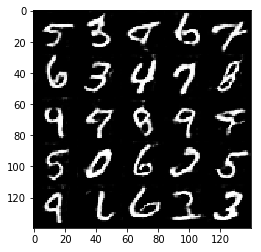

In [68]:
batch_size = 64
z_dim = 128
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 4

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/2... Batch 20/6332... Discriminator Loss: 3.0951... Generator Loss: 0.1176 This 20 batches takes:29.3 sec
Epoch 1/2... Batch 40/6332... Discriminator Loss: 4.1144... Generator Loss: 0.0307 This 20 batches takes:29.1 sec
Epoch 1/2... Batch 60/6332... Discriminator Loss: 0.7006... Generator Loss: 1.6453 This 20 batches takes:28.4 sec
Epoch 1/2... Batch 80/6332... Discriminator Loss: 0.6766... Generator Loss: 2.3554 This 20 batches takes:34.9 sec
Epoch 1/2... Batch 100/6332... Discriminator Loss: 0.4739... Generator Loss: 3.0555 This 20 batches takes:31.2 sec
Epoch 1/2... Batch 120/6332... Discriminator Loss: 0.9821... Generator Loss: 1.5928 This 20 batches takes:29.9 sec
Epoch 1/2... Batch 140/6332... Discriminator Loss: 1.7721... Generator Loss: 1.8161 This 20 batches takes:28.2 sec
Epoch 1/2... Batch 160/6332... Discriminator Loss: 1.2157... Generator Loss: 0.8090 This 20 batches takes:27.3 sec
Epoch 1/2... Batch 180/6332... Discriminator Loss: 1.2124... Generator Loss: 3.0850 

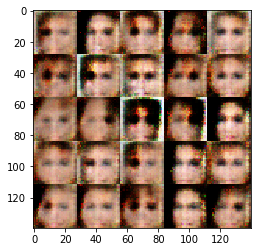

Epoch 1/2... Batch 420/6332... Discriminator Loss: 0.9297... Generator Loss: 0.7310 This 20 batches takes:27.9 sec
Epoch 1/2... Batch 440/6332... Discriminator Loss: 3.3605... Generator Loss: 4.6826 This 20 batches takes:27.1 sec
Epoch 1/2... Batch 460/6332... Discriminator Loss: 1.3443... Generator Loss: 0.6800 This 20 batches takes:27.7 sec
Epoch 1/2... Batch 480/6332... Discriminator Loss: 0.9817... Generator Loss: 2.4792 This 20 batches takes:26.5 sec
Epoch 1/2... Batch 500/6332... Discriminator Loss: 1.7899... Generator Loss: 0.4939 This 20 batches takes:26.6 sec
Epoch 1/2... Batch 520/6332... Discriminator Loss: 0.8890... Generator Loss: 1.0140 This 20 batches takes:27.4 sec
Epoch 1/2... Batch 540/6332... Discriminator Loss: 1.1233... Generator Loss: 1.4112 This 20 batches takes:27.1 sec
Epoch 1/2... Batch 560/6332... Discriminator Loss: 1.4181... Generator Loss: 1.0016 This 20 batches takes:26.6 sec
Epoch 1/2... Batch 580/6332... Discriminator Loss: 0.8092... Generator Loss: 1.3

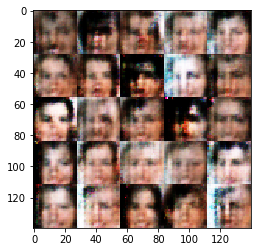

Epoch 1/2... Batch 820/6332... Discriminator Loss: 1.1675... Generator Loss: 0.8665 This 20 batches takes:27.8 sec
Epoch 1/2... Batch 840/6332... Discriminator Loss: 1.3198... Generator Loss: 0.8991 This 20 batches takes:26.6 sec
Epoch 1/2... Batch 860/6332... Discriminator Loss: 1.6336... Generator Loss: 1.3275 This 20 batches takes:26.8 sec
Epoch 1/2... Batch 880/6332... Discriminator Loss: 1.5167... Generator Loss: 0.6431 This 20 batches takes:26.8 sec
Epoch 1/2... Batch 900/6332... Discriminator Loss: 1.5209... Generator Loss: 0.5923 This 20 batches takes:27.0 sec
Epoch 1/2... Batch 920/6332... Discriminator Loss: 0.9715... Generator Loss: 1.1291 This 20 batches takes:26.4 sec
Epoch 1/2... Batch 940/6332... Discriminator Loss: 1.1344... Generator Loss: 1.2591 This 20 batches takes:26.6 sec
Epoch 1/2... Batch 960/6332... Discriminator Loss: 1.6458... Generator Loss: 0.6469 This 20 batches takes:26.0 sec
Epoch 1/2... Batch 980/6332... Discriminator Loss: 1.3840... Generator Loss: 0.5

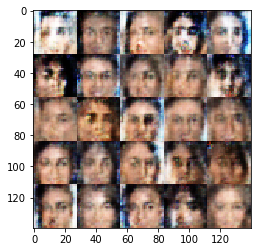

Epoch 1/2... Batch 1220/6332... Discriminator Loss: 1.4662... Generator Loss: 0.8184 This 20 batches takes:26.9 sec
Epoch 1/2... Batch 1240/6332... Discriminator Loss: 1.4981... Generator Loss: 0.7586 This 20 batches takes:25.9 sec
Epoch 1/2... Batch 1260/6332... Discriminator Loss: 1.4880... Generator Loss: 0.8241 This 20 batches takes:26.4 sec
Epoch 1/2... Batch 1280/6332... Discriminator Loss: 1.5089... Generator Loss: 0.7968 This 20 batches takes:26.5 sec
Epoch 1/2... Batch 1300/6332... Discriminator Loss: 1.7171... Generator Loss: 0.7830 This 20 batches takes:26.0 sec
Epoch 1/2... Batch 1320/6332... Discriminator Loss: 1.4092... Generator Loss: 0.5803 This 20 batches takes:25.9 sec
Epoch 1/2... Batch 1340/6332... Discriminator Loss: 1.3485... Generator Loss: 0.6112 This 20 batches takes:25.7 sec
Epoch 1/2... Batch 1360/6332... Discriminator Loss: 1.2041... Generator Loss: 0.8771 This 20 batches takes:25.7 sec
Epoch 1/2... Batch 1380/6332... Discriminator Loss: 1.3405... Generator 

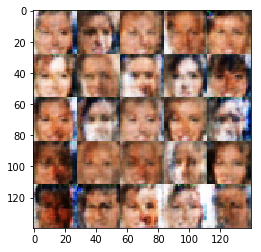

Epoch 1/2... Batch 1620/6332... Discriminator Loss: 1.1835... Generator Loss: 0.6899 This 20 batches takes:27.8 sec
Epoch 1/2... Batch 1640/6332... Discriminator Loss: 1.4145... Generator Loss: 0.7834 This 20 batches takes:26.5 sec
Epoch 1/2... Batch 1660/6332... Discriminator Loss: 1.6356... Generator Loss: 0.6880 This 20 batches takes:26.1 sec
Epoch 1/2... Batch 1680/6332... Discriminator Loss: 1.5697... Generator Loss: 0.5554 This 20 batches takes:26.3 sec
Epoch 1/2... Batch 1700/6332... Discriminator Loss: 1.4355... Generator Loss: 0.7527 This 20 batches takes:26.3 sec
Epoch 1/2... Batch 1720/6332... Discriminator Loss: 1.2580... Generator Loss: 0.5453 This 20 batches takes:25.2 sec
Epoch 1/2... Batch 1740/6332... Discriminator Loss: 1.8558... Generator Loss: 0.5979 This 20 batches takes:25.5 sec
Epoch 1/2... Batch 1760/6332... Discriminator Loss: 1.2304... Generator Loss: 0.7384 This 20 batches takes:25.3 sec
Epoch 1/2... Batch 1780/6332... Discriminator Loss: 1.2707... Generator 

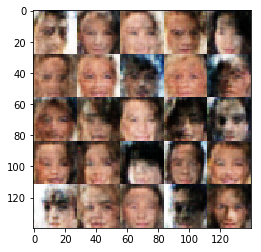

Epoch 1/2... Batch 2020/6332... Discriminator Loss: 1.1988... Generator Loss: 1.0023 This 20 batches takes:25.9 sec
Epoch 1/2... Batch 2040/6332... Discriminator Loss: 1.4008... Generator Loss: 0.6755 This 20 batches takes:25.5 sec
Epoch 1/2... Batch 2060/6332... Discriminator Loss: 1.2304... Generator Loss: 0.7004 This 20 batches takes:25.2 sec
Epoch 1/2... Batch 2080/6332... Discriminator Loss: 1.7213... Generator Loss: 0.6340 This 20 batches takes:25.5 sec
Epoch 1/2... Batch 2100/6332... Discriminator Loss: 1.4373... Generator Loss: 0.6255 This 20 batches takes:25.2 sec
Epoch 1/2... Batch 2120/6332... Discriminator Loss: 1.4556... Generator Loss: 1.0417 This 20 batches takes:25.6 sec
Epoch 1/2... Batch 2140/6332... Discriminator Loss: 1.6214... Generator Loss: 0.4833 This 20 batches takes:25.5 sec
Epoch 1/2... Batch 2160/6332... Discriminator Loss: 1.4384... Generator Loss: 0.7433 This 20 batches takes:26.8 sec
Epoch 1/2... Batch 2180/6332... Discriminator Loss: 1.4052... Generator 

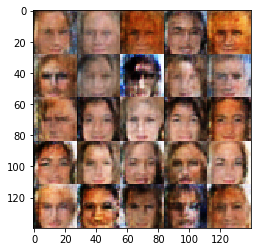

Epoch 1/2... Batch 2420/6332... Discriminator Loss: 1.5105... Generator Loss: 0.6994 This 20 batches takes:27.1 sec
Epoch 1/2... Batch 2440/6332... Discriminator Loss: 1.4939... Generator Loss: 0.5722 This 20 batches takes:27.1 sec
Epoch 1/2... Batch 2460/6332... Discriminator Loss: 1.3900... Generator Loss: 0.7240 This 20 batches takes:25.8 sec
Epoch 1/2... Batch 2480/6332... Discriminator Loss: 1.4842... Generator Loss: 0.8071 This 20 batches takes:25.3 sec
Epoch 1/2... Batch 2500/6332... Discriminator Loss: 1.6589... Generator Loss: 0.5486 This 20 batches takes:25.3 sec
Epoch 1/2... Batch 2520/6332... Discriminator Loss: 1.6116... Generator Loss: 0.6057 This 20 batches takes:25.3 sec
Epoch 1/2... Batch 2540/6332... Discriminator Loss: 1.2749... Generator Loss: 0.8846 This 20 batches takes:25.2 sec
Epoch 1/2... Batch 2560/6332... Discriminator Loss: 1.3477... Generator Loss: 0.8376 This 20 batches takes:25.4 sec
Epoch 1/2... Batch 2580/6332... Discriminator Loss: 1.4981... Generator 

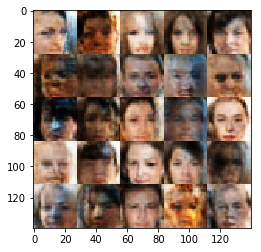

Epoch 1/2... Batch 2820/6332... Discriminator Loss: 1.3369... Generator Loss: 0.6700 This 20 batches takes:26.5 sec
Epoch 1/2... Batch 2840/6332... Discriminator Loss: 1.5048... Generator Loss: 0.8399 This 20 batches takes:25.4 sec
Epoch 1/2... Batch 2860/6332... Discriminator Loss: 1.5622... Generator Loss: 0.8692 This 20 batches takes:25.5 sec
Epoch 1/2... Batch 2880/6332... Discriminator Loss: 1.2777... Generator Loss: 0.7216 This 20 batches takes:25.5 sec
Epoch 1/2... Batch 2900/6332... Discriminator Loss: 1.4143... Generator Loss: 0.7813 This 20 batches takes:25.6 sec
Epoch 1/2... Batch 2920/6332... Discriminator Loss: 1.4620... Generator Loss: 0.8717 This 20 batches takes:25.5 sec
Epoch 1/2... Batch 2940/6332... Discriminator Loss: 1.4707... Generator Loss: 0.9023 This 20 batches takes:25.2 sec
Epoch 1/2... Batch 2960/6332... Discriminator Loss: 1.4203... Generator Loss: 0.5021 This 20 batches takes:25.2 sec
Epoch 1/2... Batch 2980/6332... Discriminator Loss: 1.3560... Generator 

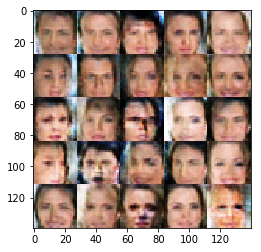

Epoch 1/2... Batch 3220/6332... Discriminator Loss: 1.4802... Generator Loss: 0.6164 This 20 batches takes:26.5 sec
Epoch 1/2... Batch 3240/6332... Discriminator Loss: 1.3899... Generator Loss: 0.8023 This 20 batches takes:25.6 sec
Epoch 1/2... Batch 3260/6332... Discriminator Loss: 1.2874... Generator Loss: 0.8364 This 20 batches takes:25.6 sec
Epoch 1/2... Batch 3280/6332... Discriminator Loss: 1.5247... Generator Loss: 0.6530 This 20 batches takes:25.4 sec
Epoch 1/2... Batch 3300/6332... Discriminator Loss: 1.3750... Generator Loss: 0.8143 This 20 batches takes:25.3 sec
Epoch 1/2... Batch 3320/6332... Discriminator Loss: 1.6172... Generator Loss: 0.8998 This 20 batches takes:25.4 sec
Epoch 1/2... Batch 3340/6332... Discriminator Loss: 1.3944... Generator Loss: 0.7129 This 20 batches takes:25.2 sec
Epoch 1/2... Batch 3360/6332... Discriminator Loss: 1.5513... Generator Loss: 0.6856 This 20 batches takes:25.3 sec
Epoch 1/2... Batch 3380/6332... Discriminator Loss: 1.5906... Generator 

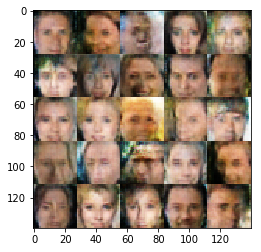

Epoch 1/2... Batch 3620/6332... Discriminator Loss: 1.4440... Generator Loss: 0.6294 This 20 batches takes:26.5 sec
Epoch 1/2... Batch 3640/6332... Discriminator Loss: 1.4331... Generator Loss: 0.6669 This 20 batches takes:25.5 sec
Epoch 1/2... Batch 3660/6332... Discriminator Loss: 1.3220... Generator Loss: 0.6999 This 20 batches takes:25.2 sec
Epoch 1/2... Batch 3680/6332... Discriminator Loss: 1.4342... Generator Loss: 0.6322 This 20 batches takes:25.2 sec
Epoch 1/2... Batch 3700/6332... Discriminator Loss: 1.3733... Generator Loss: 0.6010 This 20 batches takes:25.4 sec
Epoch 1/2... Batch 3720/6332... Discriminator Loss: 1.5770... Generator Loss: 0.5755 This 20 batches takes:25.4 sec
Epoch 1/2... Batch 3740/6332... Discriminator Loss: 1.5095... Generator Loss: 0.8183 This 20 batches takes:25.5 sec
Epoch 1/2... Batch 3760/6332... Discriminator Loss: 1.5153... Generator Loss: 0.8001 This 20 batches takes:25.2 sec
Epoch 1/2... Batch 3780/6332... Discriminator Loss: 1.4627... Generator 

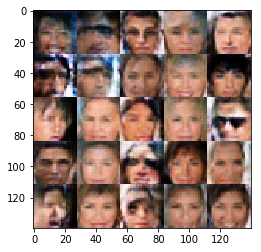

Epoch 1/2... Batch 4020/6332... Discriminator Loss: 1.5962... Generator Loss: 0.5853 This 20 batches takes:26.4 sec
Epoch 1/2... Batch 4040/6332... Discriminator Loss: 1.4257... Generator Loss: 0.6765 This 20 batches takes:25.5 sec
Epoch 1/2... Batch 4060/6332... Discriminator Loss: 1.4654... Generator Loss: 0.6847 This 20 batches takes:25.5 sec
Epoch 1/2... Batch 4080/6332... Discriminator Loss: 1.5316... Generator Loss: 0.7474 This 20 batches takes:25.0 sec
Epoch 1/2... Batch 4100/6332... Discriminator Loss: 1.3418... Generator Loss: 0.6963 This 20 batches takes:25.5 sec
Epoch 1/2... Batch 4120/6332... Discriminator Loss: 1.6032... Generator Loss: 0.7073 This 20 batches takes:25.4 sec
Epoch 1/2... Batch 4140/6332... Discriminator Loss: 1.4045... Generator Loss: 0.6287 This 20 batches takes:25.4 sec
Epoch 1/2... Batch 4160/6332... Discriminator Loss: 1.3114... Generator Loss: 0.6906 This 20 batches takes:25.3 sec
Epoch 1/2... Batch 4180/6332... Discriminator Loss: 1.6354... Generator 

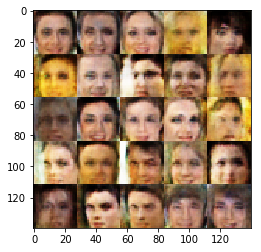

Epoch 1/2... Batch 4420/6332... Discriminator Loss: 1.6412... Generator Loss: 0.6414 This 20 batches takes:26.6 sec
Epoch 1/2... Batch 4440/6332... Discriminator Loss: 1.6412... Generator Loss: 0.7684 This 20 batches takes:25.7 sec
Epoch 1/2... Batch 4460/6332... Discriminator Loss: 1.2916... Generator Loss: 0.8648 This 20 batches takes:25.4 sec
Epoch 1/2... Batch 4480/6332... Discriminator Loss: 1.4607... Generator Loss: 0.8612 This 20 batches takes:25.6 sec
Epoch 1/2... Batch 4500/6332... Discriminator Loss: 1.4840... Generator Loss: 0.6095 This 20 batches takes:25.6 sec
Epoch 1/2... Batch 4520/6332... Discriminator Loss: 1.2639... Generator Loss: 0.8481 This 20 batches takes:25.3 sec
Epoch 1/2... Batch 4540/6332... Discriminator Loss: 1.4527... Generator Loss: 0.6968 This 20 batches takes:25.6 sec
Epoch 1/2... Batch 4560/6332... Discriminator Loss: 1.4760... Generator Loss: 0.5856 This 20 batches takes:25.6 sec
Epoch 1/2... Batch 4580/6332... Discriminator Loss: 1.4270... Generator 

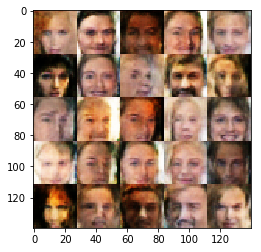

Epoch 1/2... Batch 4820/6332... Discriminator Loss: 1.3529... Generator Loss: 0.8741 This 20 batches takes:26.5 sec
Epoch 1/2... Batch 4840/6332... Discriminator Loss: 1.5498... Generator Loss: 0.7796 This 20 batches takes:25.6 sec
Epoch 1/2... Batch 4860/6332... Discriminator Loss: 1.3807... Generator Loss: 0.8205 This 20 batches takes:25.7 sec
Epoch 1/2... Batch 4880/6332... Discriminator Loss: 1.4139... Generator Loss: 0.7106 This 20 batches takes:25.6 sec
Epoch 1/2... Batch 4900/6332... Discriminator Loss: 1.3419... Generator Loss: 0.7508 This 20 batches takes:25.7 sec
Epoch 1/2... Batch 4920/6332... Discriminator Loss: 1.5235... Generator Loss: 0.5998 This 20 batches takes:25.3 sec
Epoch 1/2... Batch 4940/6332... Discriminator Loss: 1.3859... Generator Loss: 0.8887 This 20 batches takes:25.3 sec
Epoch 1/2... Batch 4960/6332... Discriminator Loss: 1.4715... Generator Loss: 0.7842 This 20 batches takes:25.7 sec
Epoch 1/2... Batch 4980/6332... Discriminator Loss: 1.6089... Generator 

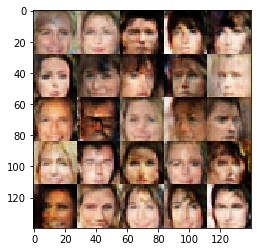

Epoch 1/2... Batch 5220/6332... Discriminator Loss: 1.3226... Generator Loss: 0.8366 This 20 batches takes:26.6 sec
Epoch 1/2... Batch 5240/6332... Discriminator Loss: 1.5087... Generator Loss: 0.6465 This 20 batches takes:25.5 sec
Epoch 1/2... Batch 5260/6332... Discriminator Loss: 1.5106... Generator Loss: 0.8848 This 20 batches takes:25.6 sec
Epoch 1/2... Batch 5280/6332... Discriminator Loss: 1.5012... Generator Loss: 0.7170 This 20 batches takes:25.5 sec
Epoch 1/2... Batch 5300/6332... Discriminator Loss: 1.4188... Generator Loss: 0.7217 This 20 batches takes:25.6 sec
Epoch 1/2... Batch 5320/6332... Discriminator Loss: 1.4193... Generator Loss: 0.7468 This 20 batches takes:25.5 sec
Epoch 1/2... Batch 5340/6332... Discriminator Loss: 1.4903... Generator Loss: 0.9135 This 20 batches takes:25.6 sec
Epoch 1/2... Batch 5360/6332... Discriminator Loss: 1.3311... Generator Loss: 0.7035 This 20 batches takes:25.6 sec
Epoch 1/2... Batch 5380/6332... Discriminator Loss: 1.4758... Generator 

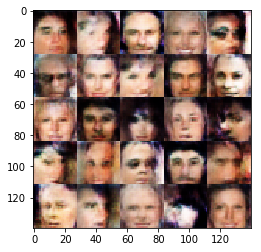

Epoch 1/2... Batch 5620/6332... Discriminator Loss: 1.4111... Generator Loss: 0.7483 This 20 batches takes:26.5 sec
Epoch 1/2... Batch 5640/6332... Discriminator Loss: 1.4904... Generator Loss: 0.7148 This 20 batches takes:25.6 sec
Epoch 1/2... Batch 5660/6332... Discriminator Loss: 1.3349... Generator Loss: 0.7023 This 20 batches takes:25.5 sec
Epoch 1/2... Batch 5680/6332... Discriminator Loss: 1.6840... Generator Loss: 0.9635 This 20 batches takes:25.3 sec
Epoch 1/2... Batch 5700/6332... Discriminator Loss: 1.4836... Generator Loss: 0.7350 This 20 batches takes:25.4 sec
Epoch 1/2... Batch 5720/6332... Discriminator Loss: 1.4124... Generator Loss: 0.7541 This 20 batches takes:25.5 sec
Epoch 1/2... Batch 5740/6332... Discriminator Loss: 1.4633... Generator Loss: 0.8444 This 20 batches takes:25.3 sec
Epoch 1/2... Batch 5760/6332... Discriminator Loss: 1.4651... Generator Loss: 0.6627 This 20 batches takes:25.8 sec
Epoch 1/2... Batch 5780/6332... Discriminator Loss: 1.3659... Generator 

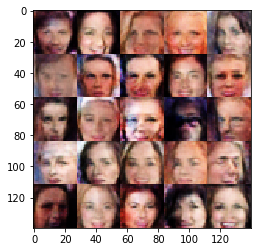

Epoch 1/2... Batch 6020/6332... Discriminator Loss: 1.3695... Generator Loss: 0.7683 This 20 batches takes:26.6 sec
Epoch 1/2... Batch 6040/6332... Discriminator Loss: 1.4718... Generator Loss: 0.6551 This 20 batches takes:25.7 sec
Epoch 1/2... Batch 6060/6332... Discriminator Loss: 1.4831... Generator Loss: 0.6417 This 20 batches takes:25.3 sec
Epoch 1/2... Batch 6080/6332... Discriminator Loss: 1.3828... Generator Loss: 0.6138 This 20 batches takes:25.7 sec
Epoch 1/2... Batch 6100/6332... Discriminator Loss: 1.5226... Generator Loss: 0.7998 This 20 batches takes:25.3 sec
Epoch 1/2... Batch 6120/6332... Discriminator Loss: 1.3489... Generator Loss: 0.7917 This 20 batches takes:25.6 sec
Epoch 1/2... Batch 6140/6332... Discriminator Loss: 1.5229... Generator Loss: 0.6597 This 20 batches takes:25.9 sec
Epoch 1/2... Batch 6160/6332... Discriminator Loss: 1.4523... Generator Loss: 0.8123 This 20 batches takes:25.3 sec
Epoch 1/2... Batch 6180/6332... Discriminator Loss: 1.3649... Generator 

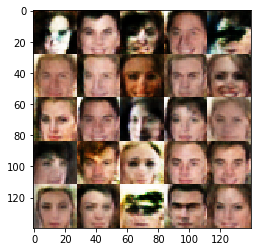

Epoch 2/2... Batch 89/6332... Discriminator Loss: 1.4577... Generator Loss: 0.6922 This 20 batches takes:23.0 sec
Epoch 2/2... Batch 109/6332... Discriminator Loss: 1.4973... Generator Loss: 0.8624 This 20 batches takes:21.7 sec
Epoch 2/2... Batch 129/6332... Discriminator Loss: 1.3779... Generator Loss: 0.7470 This 20 batches takes:21.7 sec
Epoch 2/2... Batch 149/6332... Discriminator Loss: 1.4051... Generator Loss: 0.7811 This 20 batches takes:21.7 sec
Epoch 2/2... Batch 169/6332... Discriminator Loss: 1.2967... Generator Loss: 0.7023 This 20 batches takes:21.9 sec
Epoch 2/2... Batch 189/6332... Discriminator Loss: 1.3736... Generator Loss: 0.7016 This 20 batches takes:22.2 sec
Epoch 2/2... Batch 209/6332... Discriminator Loss: 1.6355... Generator Loss: 0.6826 This 20 batches takes:21.8 sec
Epoch 2/2... Batch 229/6332... Discriminator Loss: 1.5215... Generator Loss: 0.6344 This 20 batches takes:21.7 sec
Epoch 2/2... Batch 249/6332... Discriminator Loss: 1.4283... Generator Loss: 0.71

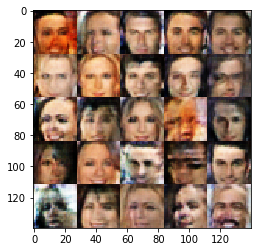

Epoch 2/2... Batch 489/6332... Discriminator Loss: 1.4297... Generator Loss: 0.6845 This 20 batches takes:22.8 sec
Epoch 2/2... Batch 509/6332... Discriminator Loss: 1.2773... Generator Loss: 0.7654 This 20 batches takes:21.7 sec
Epoch 2/2... Batch 529/6332... Discriminator Loss: 1.6084... Generator Loss: 0.6540 This 20 batches takes:21.7 sec
Epoch 2/2... Batch 549/6332... Discriminator Loss: 1.3421... Generator Loss: 0.7853 This 20 batches takes:21.8 sec
Epoch 2/2... Batch 569/6332... Discriminator Loss: 1.4937... Generator Loss: 0.7266 This 20 batches takes:21.7 sec
Epoch 2/2... Batch 589/6332... Discriminator Loss: 1.3949... Generator Loss: 0.7257 This 20 batches takes:21.7 sec
Epoch 2/2... Batch 609/6332... Discriminator Loss: 1.5901... Generator Loss: 0.8018 This 20 batches takes:21.7 sec
Epoch 2/2... Batch 629/6332... Discriminator Loss: 1.5418... Generator Loss: 0.5679 This 20 batches takes:21.7 sec
Epoch 2/2... Batch 649/6332... Discriminator Loss: 1.3596... Generator Loss: 0.6

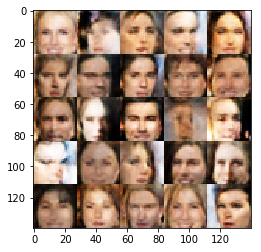

Epoch 2/2... Batch 889/6332... Discriminator Loss: 1.6266... Generator Loss: 0.9525 This 20 batches takes:22.7 sec
Epoch 2/2... Batch 909/6332... Discriminator Loss: 1.3223... Generator Loss: 0.5817 This 20 batches takes:21.8 sec
Epoch 2/2... Batch 929/6332... Discriminator Loss: 1.4076... Generator Loss: 0.7804 This 20 batches takes:21.7 sec
Epoch 2/2... Batch 949/6332... Discriminator Loss: 1.2918... Generator Loss: 0.7837 This 20 batches takes:21.7 sec
Epoch 2/2... Batch 969/6332... Discriminator Loss: 1.3141... Generator Loss: 0.7330 This 20 batches takes:21.8 sec
Epoch 2/2... Batch 989/6332... Discriminator Loss: 1.4027... Generator Loss: 1.0983 This 20 batches takes:21.7 sec
Epoch 2/2... Batch 1009/6332... Discriminator Loss: 1.3964... Generator Loss: 1.1092 This 20 batches takes:21.7 sec
Epoch 2/2... Batch 1029/6332... Discriminator Loss: 1.4035... Generator Loss: 0.6852 This 20 batches takes:21.8 sec
Epoch 2/2... Batch 1049/6332... Discriminator Loss: 1.3465... Generator Loss: 

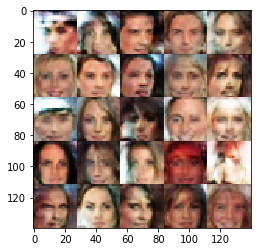

Epoch 2/2... Batch 1289/6332... Discriminator Loss: 1.4917... Generator Loss: 0.9014 This 20 batches takes:22.7 sec
Epoch 2/2... Batch 1309/6332... Discriminator Loss: 1.4016... Generator Loss: 0.7692 This 20 batches takes:21.7 sec
Epoch 2/2... Batch 1329/6332... Discriminator Loss: 1.4989... Generator Loss: 0.7259 This 20 batches takes:21.7 sec
Epoch 2/2... Batch 1349/6332... Discriminator Loss: 1.4504... Generator Loss: 0.6003 This 20 batches takes:21.7 sec
Epoch 2/2... Batch 1369/6332... Discriminator Loss: 1.5435... Generator Loss: 0.7845 This 20 batches takes:21.8 sec
Epoch 2/2... Batch 1389/6332... Discriminator Loss: 1.4724... Generator Loss: 0.7857 This 20 batches takes:21.8 sec
Epoch 2/2... Batch 1409/6332... Discriminator Loss: 1.5134... Generator Loss: 0.7245 This 20 batches takes:21.7 sec
Epoch 2/2... Batch 1429/6332... Discriminator Loss: 1.4807... Generator Loss: 0.5577 This 20 batches takes:21.7 sec
Epoch 2/2... Batch 1449/6332... Discriminator Loss: 1.4390... Generator 

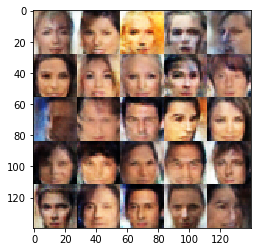

Epoch 2/2... Batch 1689/6332... Discriminator Loss: 1.3440... Generator Loss: 0.8340 This 20 batches takes:24.1 sec
Epoch 2/2... Batch 1709/6332... Discriminator Loss: 1.2937... Generator Loss: 0.9617 This 20 batches takes:21.7 sec
Epoch 2/2... Batch 1729/6332... Discriminator Loss: 1.2588... Generator Loss: 0.7673 This 20 batches takes:21.7 sec
Epoch 2/2... Batch 1749/6332... Discriminator Loss: 1.4077... Generator Loss: 0.7218 This 20 batches takes:21.7 sec
Epoch 2/2... Batch 1769/6332... Discriminator Loss: 1.4390... Generator Loss: 0.6962 This 20 batches takes:21.7 sec
Epoch 2/2... Batch 1789/6332... Discriminator Loss: 1.3162... Generator Loss: 0.6789 This 20 batches takes:21.8 sec
Epoch 2/2... Batch 1809/6332... Discriminator Loss: 1.4214... Generator Loss: 0.5620 This 20 batches takes:21.8 sec
Epoch 2/2... Batch 1829/6332... Discriminator Loss: 1.3769... Generator Loss: 0.8666 This 20 batches takes:21.7 sec
Epoch 2/2... Batch 1849/6332... Discriminator Loss: 1.5236... Generator 

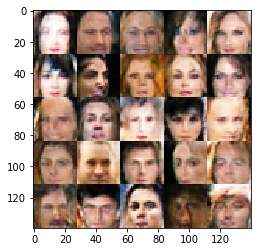

Epoch 2/2... Batch 2089/6332... Discriminator Loss: 1.3811... Generator Loss: 0.6584 This 20 batches takes:22.7 sec
Epoch 2/2... Batch 2109/6332... Discriminator Loss: 1.3748... Generator Loss: 1.0322 This 20 batches takes:21.8 sec
Epoch 2/2... Batch 2129/6332... Discriminator Loss: 1.4354... Generator Loss: 0.6799 This 20 batches takes:21.7 sec
Epoch 2/2... Batch 2149/6332... Discriminator Loss: 1.3118... Generator Loss: 0.6996 This 20 batches takes:21.8 sec
Epoch 2/2... Batch 2169/6332... Discriminator Loss: 1.4805... Generator Loss: 0.6455 This 20 batches takes:21.8 sec
Epoch 2/2... Batch 2189/6332... Discriminator Loss: 1.4621... Generator Loss: 0.5380 This 20 batches takes:21.7 sec
Epoch 2/2... Batch 2209/6332... Discriminator Loss: 1.4305... Generator Loss: 0.8796 This 20 batches takes:21.7 sec
Epoch 2/2... Batch 2229/6332... Discriminator Loss: 1.2863... Generator Loss: 0.6724 This 20 batches takes:21.8 sec
Epoch 2/2... Batch 2249/6332... Discriminator Loss: 1.4473... Generator 

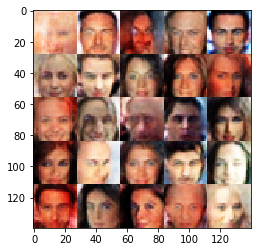

Epoch 2/2... Batch 2489/6332... Discriminator Loss: 1.3286... Generator Loss: 0.7307 This 20 batches takes:22.9 sec
Epoch 2/2... Batch 2509/6332... Discriminator Loss: 1.4701... Generator Loss: 0.8871 This 20 batches takes:21.7 sec
Epoch 2/2... Batch 2529/6332... Discriminator Loss: 1.3516... Generator Loss: 0.7240 This 20 batches takes:21.8 sec
Epoch 2/2... Batch 2549/6332... Discriminator Loss: 1.4323... Generator Loss: 0.7576 This 20 batches takes:21.7 sec
Epoch 2/2... Batch 2569/6332... Discriminator Loss: 1.3130... Generator Loss: 0.6938 This 20 batches takes:21.7 sec
Epoch 2/2... Batch 2589/6332... Discriminator Loss: 1.4776... Generator Loss: 0.7354 This 20 batches takes:21.8 sec
Epoch 2/2... Batch 2609/6332... Discriminator Loss: 1.4078... Generator Loss: 0.7558 This 20 batches takes:21.8 sec
Epoch 2/2... Batch 2629/6332... Discriminator Loss: 1.4358... Generator Loss: 0.9089 This 20 batches takes:21.7 sec
Epoch 2/2... Batch 2649/6332... Discriminator Loss: 1.4104... Generator 

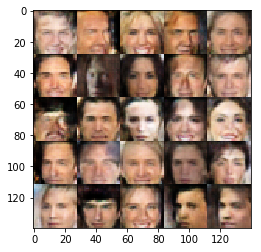

Epoch 2/2... Batch 2889/6332... Discriminator Loss: 1.4428... Generator Loss: 0.5832 This 20 batches takes:23.2 sec
Epoch 2/2... Batch 2909/6332... Discriminator Loss: 1.5174... Generator Loss: 0.7311 This 20 batches takes:23.7 sec
Epoch 2/2... Batch 2929/6332... Discriminator Loss: 1.3031... Generator Loss: 0.6720 This 20 batches takes:25.3 sec
Epoch 2/2... Batch 2949/6332... Discriminator Loss: 1.3083... Generator Loss: 0.8540 This 20 batches takes:24.8 sec
Epoch 2/2... Batch 2969/6332... Discriminator Loss: 1.3661... Generator Loss: 0.7084 This 20 batches takes:24.7 sec
Epoch 2/2... Batch 2989/6332... Discriminator Loss: 1.2920... Generator Loss: 0.8582 This 20 batches takes:24.6 sec
Epoch 2/2... Batch 3009/6332... Discriminator Loss: 1.2828... Generator Loss: 0.8827 This 20 batches takes:24.6 sec
Epoch 2/2... Batch 3029/6332... Discriminator Loss: 1.3508... Generator Loss: 0.7672 This 20 batches takes:25.3 sec
Epoch 2/2... Batch 3049/6332... Discriminator Loss: 1.2476... Generator 

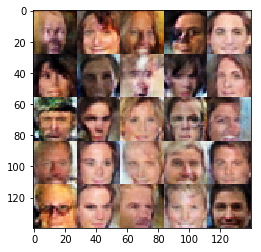

Epoch 2/2... Batch 3289/6332... Discriminator Loss: 1.4866... Generator Loss: 0.6918 This 20 batches takes:25.7 sec
Epoch 2/2... Batch 3309/6332... Discriminator Loss: 1.3307... Generator Loss: 0.7088 This 20 batches takes:24.8 sec
Epoch 2/2... Batch 3329/6332... Discriminator Loss: 1.4237... Generator Loss: 0.7966 This 20 batches takes:24.6 sec
Epoch 2/2... Batch 3349/6332... Discriminator Loss: 1.4541... Generator Loss: 0.6371 This 20 batches takes:24.8 sec
Epoch 2/2... Batch 3369/6332... Discriminator Loss: 1.3167... Generator Loss: 0.7202 This 20 batches takes:24.8 sec
Epoch 2/2... Batch 3389/6332... Discriminator Loss: 1.4939... Generator Loss: 0.7187 This 20 batches takes:24.6 sec
Epoch 2/2... Batch 3409/6332... Discriminator Loss: 1.3088... Generator Loss: 0.6630 This 20 batches takes:24.7 sec
Epoch 2/2... Batch 3429/6332... Discriminator Loss: 1.5698... Generator Loss: 0.5831 This 20 batches takes:24.7 sec
Epoch 2/2... Batch 3449/6332... Discriminator Loss: 1.2899... Generator 

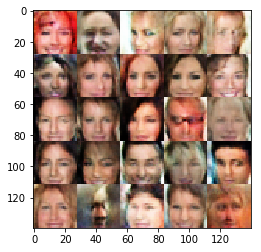

Epoch 2/2... Batch 3689/6332... Discriminator Loss: 1.4663... Generator Loss: 0.9786 This 20 batches takes:25.8 sec
Epoch 2/2... Batch 3709/6332... Discriminator Loss: 1.3653... Generator Loss: 0.7453 This 20 batches takes:24.6 sec
Epoch 2/2... Batch 3729/6332... Discriminator Loss: 1.5065... Generator Loss: 0.7885 This 20 batches takes:24.7 sec
Epoch 2/2... Batch 3749/6332... Discriminator Loss: 1.3047... Generator Loss: 0.9322 This 20 batches takes:24.6 sec
Epoch 2/2... Batch 3769/6332... Discriminator Loss: 1.4178... Generator Loss: 0.7227 This 20 batches takes:24.6 sec
Epoch 2/2... Batch 3789/6332... Discriminator Loss: 1.1782... Generator Loss: 0.9225 This 20 batches takes:24.8 sec
Epoch 2/2... Batch 3809/6332... Discriminator Loss: 1.5443... Generator Loss: 0.5422 This 20 batches takes:24.9 sec
Epoch 2/2... Batch 3829/6332... Discriminator Loss: 1.3615... Generator Loss: 0.8430 This 20 batches takes:25.3 sec
Epoch 2/2... Batch 3849/6332... Discriminator Loss: 1.3028... Generator 

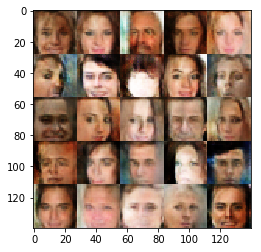

Epoch 2/2... Batch 4089/6332... Discriminator Loss: 1.5088... Generator Loss: 0.5678 This 20 batches takes:26.5 sec
Epoch 2/2... Batch 4109/6332... Discriminator Loss: 1.3410... Generator Loss: 0.7633 This 20 batches takes:25.5 sec
Epoch 2/2... Batch 4129/6332... Discriminator Loss: 1.3660... Generator Loss: 0.6403 This 20 batches takes:24.9 sec
Epoch 2/2... Batch 4149/6332... Discriminator Loss: 1.3850... Generator Loss: 0.7496 This 20 batches takes:25.3 sec
Epoch 2/2... Batch 4169/6332... Discriminator Loss: 1.2996... Generator Loss: 0.7042 This 20 batches takes:25.2 sec
Epoch 2/2... Batch 4189/6332... Discriminator Loss: 1.3558... Generator Loss: 0.8408 This 20 batches takes:24.8 sec
Epoch 2/2... Batch 4209/6332... Discriminator Loss: 1.6201... Generator Loss: 0.7751 This 20 batches takes:24.8 sec
Epoch 2/2... Batch 4229/6332... Discriminator Loss: 1.3679... Generator Loss: 0.8798 This 20 batches takes:24.7 sec
Epoch 2/2... Batch 4249/6332... Discriminator Loss: 1.3051... Generator 

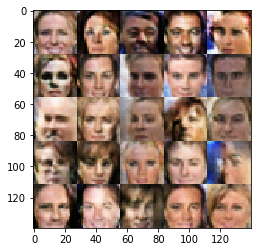

Epoch 2/2... Batch 4489/6332... Discriminator Loss: 1.5500... Generator Loss: 0.6532 This 20 batches takes:25.7 sec
Epoch 2/2... Batch 4509/6332... Discriminator Loss: 1.3509... Generator Loss: 0.8004 This 20 batches takes:24.8 sec
Epoch 2/2... Batch 4529/6332... Discriminator Loss: 1.3209... Generator Loss: 0.7356 This 20 batches takes:24.6 sec
Epoch 2/2... Batch 4549/6332... Discriminator Loss: 1.2955... Generator Loss: 0.7959 This 20 batches takes:24.6 sec
Epoch 2/2... Batch 4569/6332... Discriminator Loss: 1.3481... Generator Loss: 0.8967 This 20 batches takes:24.7 sec
Epoch 2/2... Batch 4589/6332... Discriminator Loss: 1.3475... Generator Loss: 0.6963 This 20 batches takes:24.6 sec
Epoch 2/2... Batch 4609/6332... Discriminator Loss: 1.4462... Generator Loss: 0.7878 This 20 batches takes:24.7 sec
Epoch 2/2... Batch 4629/6332... Discriminator Loss: 1.3579... Generator Loss: 0.9403 This 20 batches takes:24.9 sec
Epoch 2/2... Batch 4649/6332... Discriminator Loss: 1.4306... Generator 

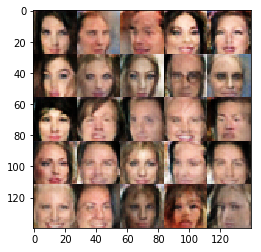

Epoch 2/2... Batch 4889/6332... Discriminator Loss: 1.5458... Generator Loss: 0.6724 This 20 batches takes:26.1 sec
Epoch 2/2... Batch 4909/6332... Discriminator Loss: 1.4322... Generator Loss: 0.8138 This 20 batches takes:24.9 sec
Epoch 2/2... Batch 4929/6332... Discriminator Loss: 1.2102... Generator Loss: 0.6454 This 20 batches takes:24.6 sec
Epoch 2/2... Batch 4949/6332... Discriminator Loss: 1.3841... Generator Loss: 0.7053 This 20 batches takes:24.8 sec
Epoch 2/2... Batch 4969/6332... Discriminator Loss: 1.2745... Generator Loss: 0.6905 This 20 batches takes:24.5 sec
Epoch 2/2... Batch 4989/6332... Discriminator Loss: 1.8006... Generator Loss: 0.5414 This 20 batches takes:25.2 sec
Epoch 2/2... Batch 5009/6332... Discriminator Loss: 1.3622... Generator Loss: 0.9480 This 20 batches takes:24.9 sec
Epoch 2/2... Batch 5029/6332... Discriminator Loss: 1.4243... Generator Loss: 0.6358 This 20 batches takes:24.6 sec
Epoch 2/2... Batch 5049/6332... Discriminator Loss: 1.3992... Generator 

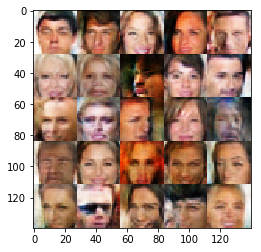

Epoch 2/2... Batch 5289/6332... Discriminator Loss: 1.1799... Generator Loss: 0.7314 This 20 batches takes:25.7 sec
Epoch 2/2... Batch 5309/6332... Discriminator Loss: 1.2321... Generator Loss: 0.7677 This 20 batches takes:24.7 sec
Epoch 2/2... Batch 5329/6332... Discriminator Loss: 1.2980... Generator Loss: 0.7902 This 20 batches takes:24.6 sec
Epoch 2/2... Batch 5349/6332... Discriminator Loss: 1.4434... Generator Loss: 0.8816 This 20 batches takes:24.7 sec
Epoch 2/2... Batch 5369/6332... Discriminator Loss: 1.4996... Generator Loss: 0.7487 This 20 batches takes:24.9 sec
Epoch 2/2... Batch 5389/6332... Discriminator Loss: 1.7206... Generator Loss: 0.5469 This 20 batches takes:24.7 sec
Epoch 2/2... Batch 5409/6332... Discriminator Loss: 1.2187... Generator Loss: 0.7482 This 20 batches takes:24.7 sec
Epoch 2/2... Batch 5429/6332... Discriminator Loss: 1.3837... Generator Loss: 0.9696 This 20 batches takes:24.9 sec
Epoch 2/2... Batch 5449/6332... Discriminator Loss: 1.2928... Generator 

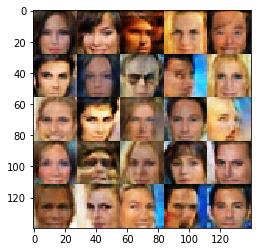

Epoch 2/2... Batch 5689/6332... Discriminator Loss: 1.2734... Generator Loss: 0.8102 This 20 batches takes:26.0 sec
Epoch 2/2... Batch 5709/6332... Discriminator Loss: 1.2781... Generator Loss: 0.7197 This 20 batches takes:25.0 sec
Epoch 2/2... Batch 5729/6332... Discriminator Loss: 1.1795... Generator Loss: 0.7490 This 20 batches takes:24.9 sec
Epoch 2/2... Batch 5749/6332... Discriminator Loss: 1.1945... Generator Loss: 0.8565 This 20 batches takes:24.7 sec
Epoch 2/2... Batch 5769/6332... Discriminator Loss: 1.2738... Generator Loss: 0.7023 This 20 batches takes:24.6 sec
Epoch 2/2... Batch 5789/6332... Discriminator Loss: 1.1643... Generator Loss: 0.7200 This 20 batches takes:24.7 sec
Epoch 2/2... Batch 5809/6332... Discriminator Loss: 1.2565... Generator Loss: 0.7182 This 20 batches takes:24.6 sec
Epoch 2/2... Batch 5829/6332... Discriminator Loss: 1.3782... Generator Loss: 0.7208 This 20 batches takes:24.6 sec
Epoch 2/2... Batch 5849/6332... Discriminator Loss: 1.2672... Generator 

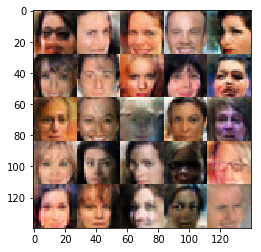

Epoch 2/2... Batch 6089/6332... Discriminator Loss: 1.4166... Generator Loss: 0.6191 This 20 batches takes:25.8 sec
Epoch 2/2... Batch 6109/6332... Discriminator Loss: 1.3620... Generator Loss: 0.8405 This 20 batches takes:24.8 sec
Epoch 2/2... Batch 6129/6332... Discriminator Loss: 1.4090... Generator Loss: 0.8234 This 20 batches takes:24.7 sec
Epoch 2/2... Batch 6149/6332... Discriminator Loss: 1.2128... Generator Loss: 0.8374 This 20 batches takes:24.7 sec
Epoch 2/2... Batch 6169/6332... Discriminator Loss: 1.3329... Generator Loss: 0.6843 This 20 batches takes:24.6 sec
Epoch 2/2... Batch 6189/6332... Discriminator Loss: 1.4556... Generator Loss: 0.6949 This 20 batches takes:24.6 sec
Epoch 2/2... Batch 6209/6332... Discriminator Loss: 1.1553... Generator Loss: 0.9814 This 20 batches takes:24.8 sec
Epoch 2/2... Batch 6229/6332... Discriminator Loss: 1.2592... Generator Loss: 0.7508 This 20 batches takes:24.6 sec
Epoch 2/2... Batch 6249/6332... Discriminator Loss: 1.4362... Generator 

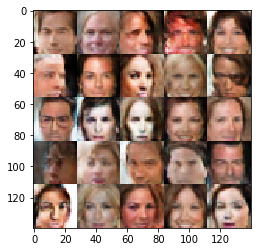

In [69]:
batch_size = 32
z_dim = 128
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.